# Problem 1- small data learning with embeddings (30%)
### We're going to use pre-trained embeddings to try to learn a text classification problem with few training examples
### This is very similar to what we did in class!
## $ \\ $
## Part 0: Load the data

In [1]:
# Restart here

In [2]:
import numpy as np
import pandas as pd
import os
%pylab inline

from sklearn.datasets import fetch_20newsgroups
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from collections import Counter


from sklearn.metrics import accuracy_score



Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [3]:
data_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), random_state=1234)
data_test = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'), random_state=1234)

## Part 1:
### a. What is the most common class in the train set?
### b. What is the out of sample (test) accuracy if we guess the most probable class?

In [4]:
# hint: you can do this in many ways, including collections.Counter or pandas
#print('most common class {}: {}'.format(most_common_class, data_train.target_names[most_common_class]))
Counter(data_train.target)
# Class 10 is the most common class

Counter({0: 480,
         1: 584,
         2: 591,
         3: 590,
         4: 578,
         5: 593,
         6: 585,
         7: 594,
         8: 598,
         9: 597,
         10: 600,
         11: 595,
         12: 591,
         13: 594,
         14: 593,
         15: 599,
         16: 546,
         17: 564,
         18: 465,
         19: 377})

In [5]:
# find the accuracy score

In [6]:
np.sum(data_test.target == 10)/data_test.target.size

0.052973977695167283

## Part 2: Turn the text into integer sequences

In [7]:
MAX_WORDS = 10000
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 50


In [8]:
# TODO
# 1. Instantiate a tokenizer with max workds
# 2. fit the tokenizer on text
# 3. Turn the text into integer sequences (train and test)
# 4. pad the sequences to a constant sequence length (train and test)
# 5. turn y into categorical variables

t = Tokenizer(num_words=MAX_WORDS)

t.fit_on_texts(data_train.data)

s_test = t.texts_to_sequences(data_test['data'])
s_train = t.texts_to_sequences(data_train['data'])


int_sequences_train = pad_sequences(s_train, maxlen=MAX_SEQ_LEN)


int_sequences_test = pad_sequences(s_test, maxlen=MAX_SEQ_LEN)

y_train =to_categorical(data_train['target'])

y_test = to_categorical(data_test['target'])


# you should have 4 variables:
# y_train, y_test, int_sequences_train, int_sequences_test
# all are numpy arrays

In [9]:
assert y_train.shape ==(11314, 20), 'something went wrong'
assert int_sequences_test.shape == (7532, 100), 'something went wrong'

## Part 3: load the GloVe embedding file

In [10]:
GLOVE_DIR = '/home/dan/MFin/MLfin'  # FIXME directory with glove
GLOVE_PATH = os.path.join(GLOVE_DIR, 'glove.6B.50d.txt')

In [11]:
def load_glove_file(filepath):
    word_to_vector = {}
    with open(filepath) as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_to_vector[word] = vector
    return word_to_vector

word_vecs = load_glove_file(GLOVE_PATH)


embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in t.word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = word_vecs.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [12]:
NUM_CLASSES = y_train.shape[1]
assert NUM_CLASSES == 20, 'something went wrong'
NUM_CLASSES

20

# Part 4: Train a model

In [38]:
from keras.models import Model, Sequential
from keras.layers import (Input, Embedding, Dropout, Dense,
GlobalAveragePooling1D, Flatten)
from keras.initializers import Constant
import keras.backend as K


# TODO
# 1. Build a model with
#  - an embedding
#  - some number of dense layers
#  - dropout
#  - don't forget to use GlobalAveragePooling to average over one dimension

K.clear_session()

word_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')

e = Embedding(input_dim=MAX_WORDS,output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQ_LEN,weights=[embedding_matrix])(word_input)
e = Dense(150, activation="relu")(e)
e = Dropout(0.3)(e)

avg_pool = GlobalAveragePooling1D()(e)

output = Dense(NUM_CLASSES, activation="softmax")(avg_pool)

# Add code here

# output = ...

model = Model(word_input, output)
model.compile(optimizer='rmsprop', loss='categorical_hinge', metrics=['accuracy'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
dense_1 (Dense)              (None, 100, 150)          7650      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 150)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                3020      
Total params: 510,670
Trainable params: 510,670
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.count_params()

510670

In [40]:
num_samples_to_train = 100
epochs = 1000  # this is a big number but won't take long with 100 samples

In [41]:

model.fit(
    int_sequences_train[:num_samples_to_train], 
    y_train[:num_samples_to_train], 
    epochs=1000, shuffle=True, batch_size=num_samples_to_train, verbose=0
)
accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(int_sequences_test), axis=1).astype(int))

0.2219861922464153

## you should be able to get more than 20% accuracy

## Part 5: Compare to others methods
### a. How does this compare to a randomly initialized, trainable embedding?

In [42]:
# TODO
# 1. Build the same model as above, but with a random embedding

K.clear_session()

word_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')

e = Embedding(input_dim=MAX_WORDS,output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQ_LEN,trainable=True)(word_input)
e = Dense(150, activation="relu")(e)
e = Dropout(0.3)(e)

avg_pool = GlobalAveragePooling1D()(e)

output = Dense(NUM_CLASSES, activation="softmax")(avg_pool)

# your code here

# output = ...

model = Model(word_input, output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])



In [43]:
model.fit(
    int_sequences_train[:num_samples_to_train], 
    y_train[:num_samples_to_train], 
    epochs=1000, shuffle=True, batch_size=num_samples_to_train, verbose=0
)
accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(int_sequences_test), axis=1).astype(int))

0.11510886882634094

## 5b: how does this compare to logistic regression trained on 100 samples?

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

data_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'))

samples_to_train = data_train['data'][:100]
samples_to_target = data_train['target'][:100]

# TODO
# 1. make a count vectorizer
# 2. fit it on only `samples_to_train` data points
# 3. trainsform train and test data into integers
# 4. fit logistic regression on just `num_samples_to_train` samples
# 5. Compute accuracy score

vec = CountVectorizer().fit(samples_to_train)
int_train =vec.transform(samples_to_train)
int_test = vec.transform(data_test['data'])
lr = LogisticRegression()
lr.fit(int_train, samples_to_target)


accuracy_score(data_test.target, lr.predict(int_test))

0.12413701540095592

## This should be approximately 10-12%

# Problem 2: Homework problem: improving BOW (30%)
There are many improvements that can be made to the bag of words represetation, without resorting to neural networks.
Here we'll try one

In [35]:
# safe to restart notebook 

In [3]:
import numpy as np
import pandas as pd
%pylab inline

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score


Populating the interactive namespace from numpy and matplotlib


In [4]:
np.random.seed(1234)

## Part 1: fit a bag of words and logistic regression to the 20 newsgroups data

In [5]:
data_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'))


In [6]:
# Todo
# 1. make a count vectorizer with max_features=20000
# 2. fit it
# 3. transform the train and test data into number
vec = CountVectorizer(max_features=20000)
vec.fit(data_train.data)
xtr = vec.transform(data_train.data)
xte = vec.transform(data_test.data)


In [7]:
# TODO
# 1. fit logistic regression
# 2. compute accuracy score
lr = LogisticRegression()
lr.fit(xtr, data_train.target)   
accuracy_score(data_test.target, lr.predict(xte))

0.60647902283590016

## Part 2: TFIDF
A big problem with counting words is that we'll tend to overweight very common words. 
These common words often carry little information

In [8]:
from collections import Counter
def word_iterator():
    """This iterator yields one word at a time from the train data"""
    for doc in data_train.data:
        for word in doc.split():
            yield word

Counter(word_iterator()).most_common(10)

[('the', 93969),
 ('to', 51191),
 ('of', 45608),
 ('a', 40042),
 ('and', 39197),
 ('is', 28204),
 ('in', 27756),
 ('I', 27143),
 ('that', 25016),
 ('for', 18066)]

### TFIDF is a scheme that combats this. 
## TFIDF = $\text{Term Frequency Inverse Document Frequency} $
# $ \\ $

# $TFIDF\left(d, t\right) \equiv \frac{\text{ Count}\left(d, t\right)}{\text{Doc-Freq}\left(d, t\right)} \equiv \text{ Count}\left(d, t\right)\,\left(1 + log\left( \frac{N_{docs}}{df_{t}}\right)\right)$
## Where
### $df_{t}$ is the number of documents in which term $t$ appears
### $N_{docs}$ is the total number of documents
### $\text{Count}\left(d,t\right)$ is the number of times term $t$ appears in document $d$ (the count matrix)

# $ \\ $ 
# $ \\ $ 
## Like this, we suppress the weight of common words

In [9]:
xtr[0]

<1x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 62 stored elements in Compressed Sparse Row format>

## 2a: write turn the count matrix into a TFIDF matrix

In [10]:
def get_idf_vector(count_matrix):
    """Get the inverse document frequence vector (shape = num_words)"""
    df = np.array((count_matrix > 0).astype(int).sum(axis=0))
    return np.log(count_matrix.shape[0] / (1+df))



#TODO(fill in this function)
def get_tfidf_matrix(count_matrix):
    """Turn a count matrix into a tfidf matrix"""
    x = get_idf_vector(xtr)
    count_matrix = count_matrix.toarray()
    count = 0
    result = np.zeros((count_matrix.shape[0],count_matrix.shape[1]))
    for i in count_matrix:
        result[count] = i * x
        count = count + 1
        
    return(result)    
        
    
    
    # TODO
#     1. get the idfs with the aboce function
#     2. turn it into a numpy array `with .toarray()`
#     3. loop the the ROWS of the matrix and transform them
        # YOUR CODE HERE

In [11]:
xtr_transformed = get_tfidf_matrix(xtr)
xte_transformed = get_tfidf_matrix(xte)

In [12]:
assert xtr_transformed.shape == xtr.shape, 'something has gone wrong'
print('It worked!')

It worked!


In [13]:
lr = LogisticRegression()
lr.fit(xtr_transformed, data_train.target)
accuracy_score(data_test.target, lr.predict(xte_transformed))

0.62692511949017526

## Part 3: Do the same with scikitlearn's implmenetation
### Happily, sklearn does this for us
### And it includes some other nice normalization

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TODO:
# 1. instantiate a TfidfVectorizer with max_features = 20000
# 2. fit it on the train data
# 3. transform train and test data into matrices
# 4. fit logistic regression on the train data
# 5. compute the accuracy score on the test data


vec = TfidfVectorizer(max_features=20000)
vec.fit(data_train.data)
x_train = vec.transform(data_train.data) 
x_test = vec.transform(data_test.data)
lr = LogisticRegression()
lr.fit(x_train, data_train.target)


# Your code here

accuracy_score(data_test.target, lr.predict(x_test))

0.67153478491768459

## Part 4: Tuning the number of words to use
## Make a plot of how the vocabulary size (`max_features`) impacts results

In [15]:
import time
start_time = time.time()
results = {}
for max_features in (100, 500, 1000, 5000, 10000, 20000, 50000, None):
    # TODO:
    # 1. instantiate a TfidfVectorizer with max_features = max_features
    # 2. fit it on the train data
    # 3. transform train and test data into matrices
    # 4. fit logistic regression on the train data
    # 5. compute the accuracy score on the test data
    
    # your code here
    
    vec = TfidfVectorizer(max_features=max_features)
    
    vec.fit(data_train.data)
    
    x_train, x_test = vec.transform(data_train.data), vec.transform(data_test.data)
    lr = LogisticRegression()
    lr.fit(x_train, data_train.target)


    if max_features is None:
        num_features = len(vec.get_feature_names())
    else:
        num_features = max_features
    results[num_features] = accuracy_score(data_test.target, lr.predict(x_test)) 

print('this took {:.2f} seconds'.format(time.time() - start_time))

this took 85.75 seconds


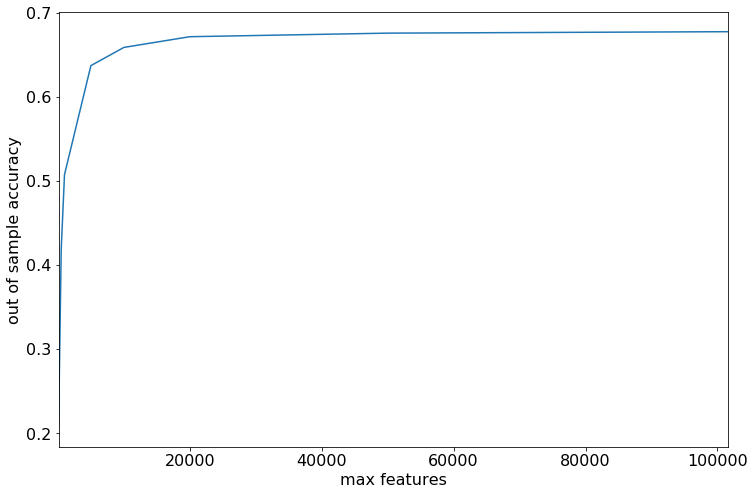

In [16]:
pd.Series(results).plot(figsize=(12,8), fontsize=16)
plt.xlabel('max features', fontsize=16)
plt.ylabel('out of sample accuracy', fontsize=16)


# Problem 3: Named entity recognition (40 %)

Named entity recognition is a common NLP task that tries to identify entities in text.

See: https://en.wikipedia.org/wiki/Named-entity_recognition

Common Types of entities include `Locations`, `People`, and `Organizations`. For example, in the sentence
# Janet Yellen, the chairwoman of the Federal Reserve, gave a speech in Colorado.
## $ \\ $ 
the goal would be to recognize
# `Janet Yellen`$_{PERSON}$, the chairwoman of the `Federal Reserve`$_{ORGANIZATION}$, gave a speech in `Colorado`$_{LOCATION}$.
# $ \\ $
# In this problem we will build a model to recognized named entities using word vectors

## Part 1: 
### Give an example of a sentence with a Person but not a location. 
### Give an example of a sentence with an organization and a location, but not a person. 

# put it here!
The US President walked away.

The Federal Reserve is located in Washington DC. 

# Part 2: building a model
# $ \\ $
### The goal of this section is to build a model to take a sentence (list of words) and identify what kind of tag each word is
# $ \\ $
## Why is this problem hard:
### Some words will be the same tag all the time. For example `Colorado` is almost always a `LOCATION`
### Some words depend on context: above `federal` and `reserve` are `ORGANIZATION` but I can write `I would like to reserve a table.`

# $ \\ $
## To combat this issue we will make a very simple model but taking a 3-word window around every word
  - For every word, we will take the word vector of that word and the two surrounding words

### Example: `I went to the store` will be represented as 
 - `I` $\rightarrow$ `UKNOWN` - `I` - `went` $\rightarrow$ $\left[ V_{UKNOWN}, V_{I}, V_{went}\right]$
 - `went` $\rightarrow$ `I` - `went` - `to`$\rightarrow$ $\left[V_{I}, V_{went},  V_{to}\right]$
 - `to` $\rightarrow$ `went` - `to` - `the`$\rightarrow$ $\left[V_{went},  V_{to}, V_{the}\right]$
 - ...
#### Where 
 - $V_{word_{i}}$ is the representation for $word_{i}$
 - `UKNOWN` is the token for unknown or boundary words
 
Like this, we will encode some __context__ around every word. Each word here will be encoded as a $3 * d_{embedding}$-dimensional vector.

In [17]:
import numpy as np
import pandas as pd
%pylab inline

import re

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.initializers import Constant
import keras.backend as K
from keras.utils import to_categorical

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [18]:
def load_glove_file(filepath):
    """Load a glove embedding from a file"""
    word_to_vector = {}
    with open(filepath) as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_to_vector[word] = vector
    return word_to_vector

def load_dataset(fname):
    """Load an NER dataset"""
    docs = []
    with open(fname) as fd:
        cur = []
        for line in fd:
            line = line.lower()
            # new sentence on -DOCSTART- or blank line
            if re.match(r"-DOCSTART-.+".lower(), line) or (len(line.strip()) == 0):
                if len(cur) > 0:
                    docs.append(cur)
                cur = []
            else: # read in tokens
                cur.append(line.strip().split("\t",1))
        # flush running buffer
        if cur:
            docs.append(cur)
    return docs

In [21]:
import os
GLOVE_DIR = '/home/dan/MFin/MLfin/'  # FIXME directory with glove
DATA_PATH = '/home/dan/MFin/MLfin/ml_finance/hw2/train.conll'  # where you downloaded the data

word_vecs = load_glove_file(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
docs = load_dataset(DATA_PATH)

In [22]:
correct_first_doc = [
    ['eu', 'org'],
    ['rejects', 'o'],
    ['german', 'misc'],
    ['call', 'o'],
    ['to', 'o'],
    ['boycott', 'o'],
    ['british', 'misc'],
    ['lamb', 'o'],
    ['.', 'o'],
]
assert len(word_vecs) == 400000, 'word vectors did not load properly'
assert word_vecs['the'].shape == (50,), 'word vectors did not load properly'
assert len(docs) == 14041, 'something has gone wrong with data loading'
assert docs[0] == correct_first_doc, 'something has gone wrong with data loading'


In [23]:
MAX_WORDS = len(word_vecs)  # max number of words to use in the embedding
UNKNOWN = 'UUUNKKK'.lower()  # token for unknown word
UNKNOWN_WORD_INDEX = 0
EMBEDDING_DIM = 50  # dimension of embedding
NULL_TAG = 'o'  # tags that are not a named entity

# Some derived quantities
TAGS = (NULL_TAG, 'loc', 'per', 'org', 'misc')
NUM_TO_TAG = dict(enumerate(TAGS))
TAG_TO_NUM = {tag: num for num, tag in NUM_TO_TAG.items()}

NUM_CLASSES = len(TAGS)
assert NUM_CLASSES == 5, 'somethig has gone wrong'

WINDOW = 1

In [27]:
word_to_num = {word: idx + 1 for idx, word in enumerate(word_vecs.keys())}
num_to_word = {num: word for word, num in word_to_num.items()}

word_to_num[UNKNOWN] = UNKNOWN_WORD_INDEX
num_to_word[UNKNOWN_WORD_INDEX] = UNKNOWN

assert word_to_num['the'] > 10, '"the" is not a common word- something has gone wrong.'

'shihad'

In [28]:
# Create an embedding matrix
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in word_to_num.items():#tok.word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = word_vecs.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


## Creating windowed-word sequences

In [29]:
def seq_to_windows(words, tags, word_to_num, tag_to_num, left=WINDOW, right=WINDOW):
    """Turn sequences of words and tags into corresponding windowed sequences"""
    X = []
    y = []
    word_dict = {ind: word for ind, word in enumerate(words)}
    for i, word in enumerate(words):
        if word == "<s>" or word == "</s>":
            continue # skip sentence delimiters
        word_seq = [word_dict.get(i + ii, UNKNOWN) for ii in range(-left, 1 + right)]
        int_seq = [word_to_num.get(w, UNKNOWN_WORD_INDEX) for w in word_seq]
        tagn = tag_to_num[tags[i]] 
        X.append(int_seq)
        y.append(tagn)
    return array(X), array(y)


def window_row_to_vector(window_row, embed_matrix):
    """Turn a row of integers (np.array) into a single word vector"""
    # TODO: implement this
    return np.hstack([embed_matrix[i] for i in window_row]) # to be removed



In [30]:
words, tags = zip(*docs[0])
x, y = seq_to_windows(words, tags, word_to_num=word_to_num, tag_to_num=TAG_TO_NUM)

In [31]:
assert x.dtype == np.int, 'x has the wrong data type'
reconstructed_words = [num_to_word[num] for num in x[:, WINDOW]]
assert tuple(reconstructed_words) == words, 'word transformation has gone wrong'

In [39]:
all_xs = []
all_ys = []
for doc in docs:
#     TODO
#     1. unpack the words and the tags from `docs`
#     2. use `seq_to_windows` to turn `words` and `tag` into `x` and `y`
#     3. turn `x` into a single vector with `window_row_to_vector`
    
    words, tags = zip(*doc)
    
    # Your code here
    x,y = seq_to_windows(words,tags,word_to_num,TAG_TO_NUM)
    
    x = window_row_to_vector(x.T,embedding_matrix)
    
    all_xs.extend(x)
    all_ys.extend(y)
    
    
all_xs = np.vstack(all_xs)
all_ys = np.vstack(all_ys)


all_ys = to_categorical(all_ys)
assert all_xs.shape[0] == all_ys.shape[0]

In [53]:
# TODO
# 1. make an array of indices to be shuffled with `np.arange`
# 2. shuffle the indices randomly
# 3. use the shuffled indices to shuffle `all_xs` and `all_ys`

# YOUR CODE HERE
inds = np.arange(all_xs.shape[0])
np.random.shuffle(inds)

all_xs, all_ys = all_xs[inds], all_ys[inds]


cut = int(0.8 * all_xs.shape[0])
x_train, x_val = all_xs[:cut], all_xs[cut:]
y_train, y_val = all_ys[:cut], all_ys[cut:]

In [54]:
K.clear_session()

#TODO
# 1. build a network with 
#  - an input layer
#  - some number of dense layers and dropout

word_input = Input(shape=(x_train.shape[1],))  # to be removed

x = Dense(100, activation='relu')(word_input)
x = Dropout(0.3)(x)

output = Dense(y_train.shape[1], activation='softmax')(x)


# YOUR CODE HERE


model = Model(word_input, output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [55]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True, epochs=16, batch_size=256)

Train on 162896 samples, validate on 40725 samples
Epoch 1/16
162896/162896 [==============================] - 3s 20us/step - loss: 0.2880 - acc: 0.9101 - val_loss: 0.1879 - val_acc: 0.9432
Epoch 2/16
162896/162896 [==============================] - 2s 11us/step - loss: 0.1866 - acc: 0.9423 - val_loss: 0.1605 - val_acc: 0.9502
Epoch 3/16
162896/162896 [==============================] - 2s 12us/step - loss: 0.1654 - acc: 0.9489 - val_loss: 0.1476 - val_acc: 0.9547
Epoch 4/16
162896/162896 [==============================] - 2s 11us/step - loss: 0.1529 - acc: 0.9530 - val_loss: 0.1399 - val_acc: 0.9581
Epoch 5/16
162896/162896 [==============================] - 2s 11us/step - loss: 0.1467 - acc: 0.9552 - val_loss: 0.1352 - val_acc: 0.9599
Epoch 6/16
162896/162896 [==============================] - 2s 11us/step - loss: 0.1399 - acc: 0.9569 - val_loss: 0.1308 - val_acc: 0.9606
Epoch 7/16
162896/162896 [==============================] - 2s 11us/step - loss: 0.1355 - acc: 0.9586 - val_loss: 0

('swansea', '1', 'lincoln', '2')

## We need to process new sentences so that they can be processed by our network

In [70]:
def preprocess_sentence(sentence):
    """Preprocess a sentence into word vectors for the model
    
    TODO:
        1. split sentence into words (and make lowercase)
        2. make each word into a 3-word window (use seq_to_windows)
            - this will require the creating some fake tags in the right format
                in order to pass to `seq_to_windows`
        3. turn each row (3-word window) into a single vector (use window_row_to_vector)
        4. turn the list of 150-d vectors into a numpy matrix shape (n_words x 150)
    """
    words = sentence.lower().split()
    # your code here
    fake_tags =tuple(random.choice(list(TAG_TO_NUM.keys()),len(words)))
    # your code here
    x, y = seq_to_windows(words, fake_tags,word_to_num,TAG_TO_NUM)
    
    x = window_row_to_vector(window_row=x.T, embed_matrix=embedding_matrix)
    return(x)

In [71]:
assert (
    preprocess_sentence('This sentence has five words').shape == 
    (5, EMBEDDING_DIM * (1 + 2 * WINDOW))
), '`preprocess_sentence` does not work'

In [83]:
# TODO
# 1. Come up with a sentence
# 2. preprocess it for consumption by the network with `preprocess_sentence`
# 3. use the model to make predictions
# 4. Turn the predicted probabilities into predicted labels
# 5. print the output nicely  (done for you)


# Make up some of your own sentences
sentence = 'Dan Smith quit after Sears Inc announced it would acquire The Federal Reserve Inc for 17 dollars .'

processed_sentence = preprocess_sentence(sentence)
predictions = model.predict(processed_sentence)
predicted_labels = np.argmax(predictions, axis=1)


maxlen = max(map(len, sentence.split()))
for word, label in zip(sentence.split(), predicted_labels):
    print('{} :  {}'.format(word.ljust(maxlen), NUM_TO_TAG[label]))

Dan       :  per
Smith     :  per
quit      :  o
after     :  o
Sears     :  org
Inc       :  org
announced :  o
it        :  o
would     :  o
acquire   :  o
The       :  o
Federal   :  o
Reserve   :  org
Inc       :  org
for       :  o
17        :  o
dollars   :  o
.         :  o


In [80]:
NUM_TO_TAG[]

TypeError: unhashable type: 'slice'